In [1]:
import Pkg; 
Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, StableRNGs

  Activating project at `/ws`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0


##### Goal
The goal is to create an HMM with 4 classes, where inference in performed in an online setting
##### Datageneration

In [2]:
s_init = [1, 0, 0, 0]
A = [12 5 0 0;
     0 12 5 0;
     0 0 12 5;
     5 0 0 12]
B = [10 5 2 1;
     5 10 5 2;
     2 5 10 5;
     1 2 5 10]
rng = StableRNG(42)

s = []
push!(s, s_init)
println(s)

datastream   = Subject(Vector{Float64})
observations = labeled(Val((:y, )), combineLatest(datastream))


# Function to return a one-hot encoded state based on a Categorical distribution
function rand_vec(rng, distribution::Categorical)
  k = ncategories(distribution)
  s = zeros(k)
  drawn_category = rand(rng, distribution)
  s[drawn_category] = 1
  
  return s
end

Any[[1, 0, 0, 0]]


rand_vec (generic function with 1 method)

In [3]:
# Function to genereate a single state-observation pair
function generate_data(rng, s_past)
  s_prev = last(s_past)
  s_prob_vec = A * s_prev
  s = rand_vec(rng, Categorical(s_prob_vec / sum(s_prob_vec)))
  y_prob_vec = B * s
  y = rand_vec(rng, Categorical(s_prob_vec / sum(s_prob_vec)))

  return s, y
end

generate_data (generic function with 1 method)

In [4]:
test_subscription = subscribe!(observations,
  (new_observation) -> println("Got new obersvation: ", new_observation)
)

CombineLatestSubscription()

In [5]:
#testing the generate_data() function
for i in 1:3
  s_new, y_new = generate_data(rng, s)
  next!(datastream, y_new)
  push!(s, s_new)
end

println(s)

Got new obersvation: (y = [1.0, 0.0, 0.0, 0.0],)
Got new obersvation: (y = [0.0, 0.0, 0.0, 1.0],)
Got new obersvation: (y = [0.0, 0.0, 0.0, 1.0],)
Any[[1, 0, 0, 0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0]]


In [6]:
unsubscribe!(test_subscription)

# Reseting the s array
s = []
push!(s, s_init)
println(s)

Any[[1, 0, 0, 0]]


##### Model

In [7]:
@model function hidden_markov_model(_A, _B, _s_prev, y)
  A ~ MatrixDirichlet(_A)
  B ~ MatrixDirichlet(_B)

  s_prev ~ Categorical(_s_prev)

  s ~ Transition(s_prev, A)
  y ~ Transition(s, B)
end

@constraints function hidden_markov_model_constraints()
  q(s, s_prev, B, A) = q(s, s_prev)q(B)q(A)
end 

hidden_markov_model_autoupdates = @autoupdates begin
  _s_prev = params(q(s_prev))
  _A = params(q(A))
  _B = params(q(B))
end

@autoupdates begin
    _s_prev = params(q(s_prev))
    _A = params(q(A))
    _B = params(q(B))
end


In [8]:
imarginals = @initialization begin
  q(A) = MatrixDirichlet([5 1 1 1;
                          1 5 1 1;
                          1 1 5 1;
                          1 1 1 5])
  q(B) = MatrixDirichlet([10 1 1 1;
                          1 10 1 1;
                          1 1 10 1;
                          1 1 1 10])
  q(s) = vague(Categorical, 4)
  q(s_prev) = Categorical(fill(0.25, 4))
  q(y) = vague(Categorical, 4)
end

ireturnvars = (
  A = KeepLast(),
  B = KeepLast(),
  s = KeepLast()
)

engine = infer(
  model          = hidden_markov_model(),
  constraints    = hidden_markov_model_constraints(),
  datastream     = observations,
  autoupdates    = hidden_markov_model_autoupdates,
  initialization = imarginals,
  keephistory    = 100,
  historyvars    = ireturnvars,
  autostart      = false
)


RxInferenceEngine:
  Posteriors stream    | enabled for (A, s, B, s_prev)
  Free Energy stream   | disabled
  Posteriors history   | available for (A, s, B)
  Free Energy history  | unavailable
  Enabled events       | [  ]

In [9]:
#s_update_subscription = subscribe!(engine.posteriors[:s],
  #(new_posterior_s) -> println("New posterior: ", new_posterior_s)
#)

RxInfer.start(engine)

In [10]:
for i in 1:5000
  s_new, y_new = generate_data(rng, s)
  next!(datastream, y_new)
  push!(s, s_new)
end
  

In [11]:
RxInfer.stop(engine)
#unsubscribe!(s_update_subscription)

println("test")

test


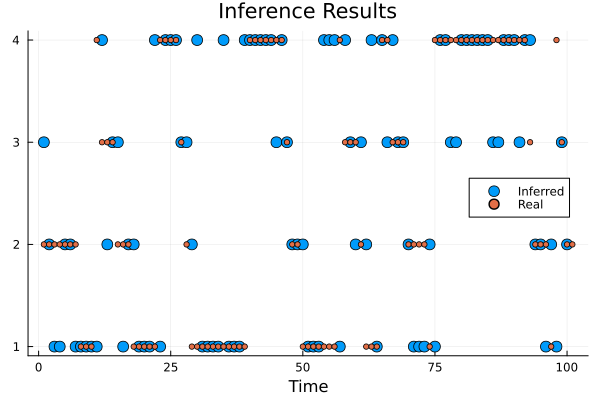

In [12]:
p1 = scatter(argmax.(ReactiveMP.probvec.(engine.history[:s]))[1:100],
                        title = "Inference Results",
                        label = "Inferred",
                        ms = 6, 
                        legend = :right,
                        xlabel = "Time",
                        #yticks = ([1, 2, 3, 4], ["Exists", "Not Exists"]),
                        #size = (900, 500)
                        )

p1 = scatter!(argmax.(s[4901:5001]),
                        label = "Real",
                        ms = 3
                        )

display(p1)


In [13]:
A_infered = last(engine.history[:A])
B_infered = last(engine.history[:B])
println("Inferred A: ", A_infered)
println("Inferred B: ", B_infered)

println("test")


Inferred A: MatrixDirichlet{Float64, Matrix{Float64}}(
a: [5.254438310598938 1.0306253544857862 5.720021674261115 624.882631862543; 1.0305350291084254 5.24560762848079 1.8388943959452995 923.1020962119229; 1.037525950923273 1.0386270681985303 11.628544626255927 1218.9744592939096; 1.1304157125562853 1.1286736044498324 3.1318827402081864 2225.825020536152]
)

Inferred B: MatrixDirichlet{Float64, Matrix{Float64}}(
a: [580.8678134643683 82.75904652710746 229.4976135687507 334.12552643977403; 23.001359656428704 790.3642299035881 84.77661921795597 368.1077912220289; 18.25894742972684 36.56359496610334 874.07750387882 335.3499537253478; 19.759596651364692 26.530261868657135 49.32742027375828 1198.6327212062195]
)

test
